In [81]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [82]:
zebra_path = '../images/zebra.jpg'
image = imageio.imread(zebra_path).astype(np.uint8)

In [116]:
filtered = 1 - (image.min(axis=2) < 160) * (image.max(axis=2) > 180)

mask = np.zeros(image.shape).astype(int)
entry_point = (200, 300)

to_visit = [entry_point]
seen = {entry_point}

while len(to_visit) > 0:
    p = to_visit.pop()
    mask[p] = 1
    right = (p[0], p[1]+1)
    left = (p[0], p[1]-1)
    up = (p[0]+1, p[1])
    down = (p[0]-1, p[1])
    for ngh in [right, left, up, down]:
        if (not ngh in seen) and filtered[ngh]:
            to_visit.append(ngh)
            seen.add(ngh)

In [199]:
target = image*(1-mask)

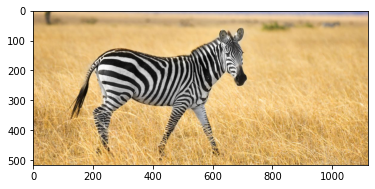

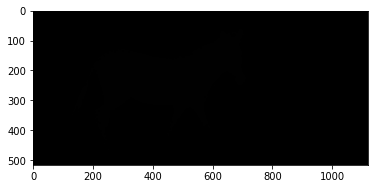

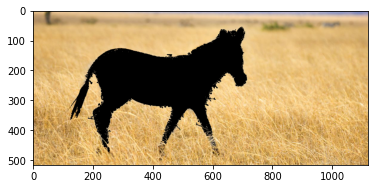

In [200]:
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(target)
plt.show()

In [149]:
w, h = 10, 10
gap_x, gap_y = w//2, h//2

In [150]:
def extract_patch(img, p):
    return img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x]

In [204]:
def apply_path(img, p, patch):
    img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x] = patch

In [205]:
def Vp(p, x):
    patch_p = extract_patch(image, p)
    patch_x = extract_patch(image, x)
    patch_mask = extract_patch(mask, p)
    return (patch_mask*(patch_p - patch_x)**2).sum()

In [206]:
Vp(entry_point, (300,40))

34702

In [207]:
def Vpq(p, q, xp, xq):
    image_p = np.zeros(image.shape)
    apply_path(image_p, p, extract_patch(image, p))
    image_q = np.zeros(image.shape)
    apply_path(image_q, q, extract_patch(image, q))
    
    return ((mask * image_p * image_q)**2).sum()

In [208]:
Vpq(entry_point, (entry_point[0], entry_point[1]+1), labels[0], labels[1])

400325312052.0

In [111]:
labels = list(zip(np.random.randint(0, image.shape[0], 10), np.random.randint(0, image.shape[1], 10)))

In [210]:
nodes = [(300, 400), (300, 405), (305, 400), (305, 405)]
edges = [(0, 1), (1, 0), (0, 2), (2, 0), (1, 3), (3, 1), (2, 3), (3, 2)]

In [211]:
nodes, edges = [], []

for i in range(10):
    nodes.append((300+i*5, 400))
    nodes.append((300+i*5, 405))
    edges.append((2*i, 2*i+1))
    edges.append((2*i+1, 2*i))
    if i > 0:
        edges.append((2*i, 2*(i-1)))
        edges.append((2*(i-1), 2*i))
        edges.append((2*i+1, 2*(i-1)+1))
        edges.append((2*(i-1)+1, 2*i+1))

In [181]:
def F(x):
    f = sum([Vp(nodes[i], labels[x[i]]) for i in range(len(nodes))])
    for i, j in edges:
        f += Vpq(nodes[i], nodes[j], labels[x[i]], labels[x[j]])
    return f

In [182]:
x = [2, 4, 1, 3, 5, 0, 1, 1]
F(x)

222325276803.0

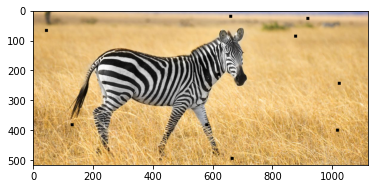

In [212]:
# Show labels

img = image.copy()
for p in labels:
    img[p[0]-padding_w:p[0]+padding_w, p[1]-padding_h:p[1]+padding_h] = 0

plt.imshow(img)
plt.show()

In [213]:
n_edges = len(edges)
n_labels = len(labels)
n_nodes = len(nodes)

In [214]:
messages = np.zeros((n_edges, n_labels))

In [215]:
messages_update = np.zeros(messages.shape)
for k, (i, j) in enumerate(edges):
    p, q = nodes[i], nodes[j]
    for i_label, xq in enumerate(labels): 
        messages_update[k][i_label] = min([Vp(p, xp) + Vpq(p, q, xp, xq) for xp in labels])
messages = messages_update

In [216]:
beliefs = np.zeros((n_nodes, n_labels))

In [217]:
for i_node, p in enumerate(nodes):
    for i_label, xp in enumerate(labels):
        beliefs[i_node][i_label] = - Vp(p, xp) - sum([messages[i_edge, i_label] for i_edge, (_, j) in enumerate(edges) if j == i_node])

In [218]:
x_hat = np.argmax(beliefs, axis=1)

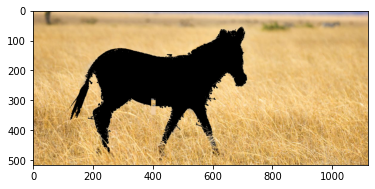

In [219]:
res = target.copy()
for i_node, i_label in enumerate(x_hat):
    apply_path(res, nodes[i_node], extract_patch(image, labels[i_label]))
plt.imshow(res)
plt.show()